# Strategy: Smart Allocations: Unleashing the Sharpe Ratio with Diversified Stocks

### Thomas Polstra, PhD

##### [GitHub](https://github.com/thomaspolstra/Quant_Materials_Polstra_Public.git) -- [Academic Website](https://thomaspolstra.github.io/) -- [Email](mailto:thomaspolstra@gmail.com)


In this analysis, we will explore the potential of maximizing the Sharpe Ratio on a diverse collection of stocks. We will consider a carefully selected set of stocks from various industries, each contributing to the portfolio's diversification. The chosen tickers are as follows:

- GOOGL - Alphabet Inc. Class A (Communication Services)
- TSLA - Tesla, Inc. (Consumer Discretionary)
- VZ - Verizon Communications Inc. (Communication Services)
- CVX - Chevron Corporation (Energy)
- ADBE - Adobe Inc. (Technology)
- MRK - Merck & Co., Inc. (Health Care)
- NKE - Nike, Inc. (Consumer Discretionary)
- MRNA - Moderna, Inc. (Health Care)
- MCD - McDonald's Corporation (Consumer Discretionary)
- CRM - Salesforce.com Inc. (Technology)
- CMCSA - Comcast Corporation (Communication Services)
- GS - The Goldman Sachs Group, Inc. (Financials)
- COST - Costco Wholesale Corporation (Consumer Staples)
- INTC - Intel Corporation (Technology)
- PEP - PepsiCo, Inc. (Consumer Staples)

These stocks come from various sectors, including technology, health care, consumer discretionary, communication services, energy, financials, and more. We will collect historical returns for these stocks and explore the potential of constructing an optimized portfolio with the maximum Sharpe Ratio.

We will collect historical returns for these stocks over the past 18 months. Using the first 12 months of data, we will determine the optimal weights for each stock to construct a portfolio with the maximum Sharpe Ratio. Then, we will apply these weights to the last 6 months of data and analyze the performance of the portfolio.

The Sharpe Ratio serves as a risk-adjusted performance measure, considering both returns and volatility. By allocating our investments across a diversified set of stocks, we aim to achieve better risk-adjusted returns and improve the overall performance of our portfolio.

To assess the performance of our strategy, we will create a tearsheet using pyfolio, and benchmark our portfolio returns against the S&P 500 index returns.

Through this analysis, we will gain valuable insights into the effectiveness of our investment strategy and the potential of maximizing the Sharpe Ratio using a diversified collection of stocks.

## Performance Summary
The investment strategy performed poorly during the testing period (not suprising as not much effort was put into the strategy. The purpose of this notebook is to observe that naively investing in random stocks that maximize sharpe ratio over a training period may not be a good investment strategy.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import scipy.optimize as sc
import pyfolio as pf
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')

In [2]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix, stockData

def plotPrices(stocks,start,end):
    meanReturns, covMatrix, stockData = getData(stocks, start, end)
    for stock in stocks:
        plt.plot(stockData[stock], label = stock)
        plt.plot(stockData)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Stock Prices', size = 20)
        plt.legend()
        
def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(
            np.dot(weights.T,np.dot(covMatrix, weights))
           )*np.sqrt(252)
    return returns, std

def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - (pReturns - riskFreeRate)/pStd




def maxSR(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0, 1), min_asset_percentage=0):
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    
    # Add the constraint for minimum asset percentage
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    # Set a lower bound for each asset weight to enforce the minimum asset percentage
    bounds = tuple((min_asset_percentage, 1.0) for _ in range(numAssets))
    
    result = sc.minimize(negativeSR, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


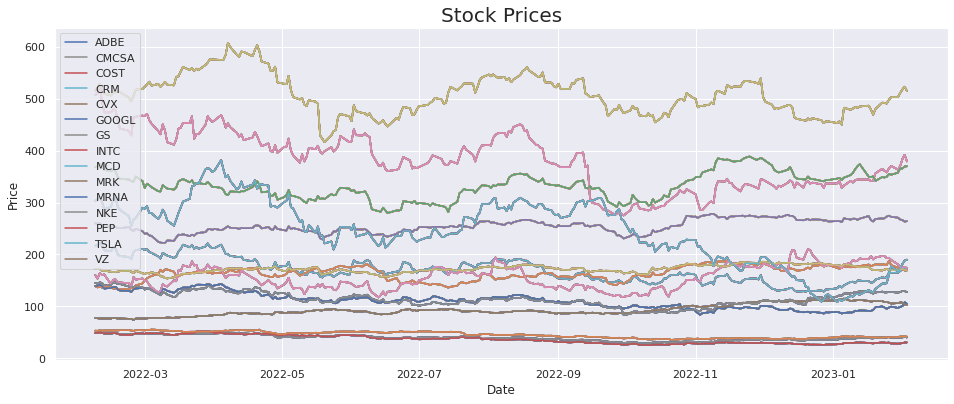

In [3]:
#Gather return data for the testing period
stocks = sorted(['GOOGL', 'TSLA', 'VZ', 'CVX', 'ADBE', 'MRK', 'NKE', 'MRNA', 'MCD', 'CRM', 'CMCSA', 'GS', 'COST', 'INTC', 'PEP'])
#all_stocks = stocks +['^GSPC']
end1 = datetime.date.today()
end2 = end1 - datetime.timedelta(days = 183)
start = end1 - datetime.timedelta(days = 548)
meanReturnsTrain, covMatrixTrain, stockDataTrain = getData(stocks, start, end2)
plotPrices(stocks,start,end2)
plt.show()

In [4]:
#Find weights which maximize Sharpe Ratio over training period, we invest at least 3% of our portfolio in each asset
weights  = maxSR(meanReturnsTrain, covMatrixTrain, min_asset_percentage = 0.01).x
weights_rounded = [round(weight,2) for weight in weights]
r, v = portfolioPerformance(weights, meanReturnsTrain, covMatrixTrain)
print(f'Asset weights: {weights_rounded}')
print(f'Returns over training period: {round(r*100, 2)}%')
print(f'Volatility over training period: {round(v*100, 2)}%')
print(f'Naive Sharpe Ratio over training period: {round(r/v,2)}')

Asset weights: [0.01, 0.01, 0.01, 0.01, 0.13, 0.01, 0.01, 0.01, 0.01, 0.74, 0.01, 0.01, 0.01, 0.01, 0.01]
Returns over training period: 24.95%
Volatility over training period: 17.79%
Naive Sharpe Ratio over training period: 1.4


In [6]:
#Apply weights to investments over the testing period and compare to S&P 500 index
meanReturnsTest, covMatrixTest, stockDataTest = getData(stocks, end2, end1)
returnsTest = pd.DataFrame()
for ticker in stocks:
    returnsTest[ticker] = stockDataTest[ticker].pct_change()
    
returnsTest = returnsTest.dropna()
strategy_returns = pd.DataFrame()

for ticker in stocks:
    stockDataTest[f"{ticker} returns"] = stockDataTest[ticker].pct_change()
    strategy_returns[ticker] = stockDataTest[ticker + ' returns'] * weights_rounded[stocks.index(ticker)]

strategy_returns['strat returns'] = strategy_returns.sum(axis=1)
strategy_returns = strategy_returns.dropna()

sp_data = yf.download('^GSPC', end2, end1)
sp_data['S&P returns'] = sp_data['Close'].pct_change()
sp_data = sp_data.dropna()
sp_data1 = sp_data['S&P returns']

combined_data = pd.concat([strategy_returns['strat returns'], sp_data1], axis=1)


# Create the pyfolio tearsheet
pf.create_full_tear_sheet(combined_data['strat returns'], benchmark_rets=combined_data['S&P returns'])

# Get the matplotlib figure and axes
fig, ax = plt.gcf(), plt.gca()

# Optionally, customize the figure or save it to a file
# Example: Save the tearsheet figure to a file
#fig.savefig('tearsheet.png', dpi=300)

# Close the figure to prevent it from being displayed
plt.close(fig)


[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  1 of 1 completed


Start date,2023-02-07
End date,2023-08-04
Total months,5
,Backtest
Annual return,2.343%
Cumulative returns,1.146%
Annual volatility,15.84%
Sharpe ratio,0.22
Calmar ratio,0.31
Stability,0.05
Max drawdown,-7.455%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.46,2023-05-08,2023-07-17,NaT,NaN
1,5.74,2023-03-06,2023-03-17,2023-04-05,23
2,3.76,2023-02-13,2023-02-28,2023-03-06,16
3,2.48,2023-04-13,2023-04-26,2023-05-02,14
4,0.77,2023-05-02,2023-05-04,2023-05-08,5


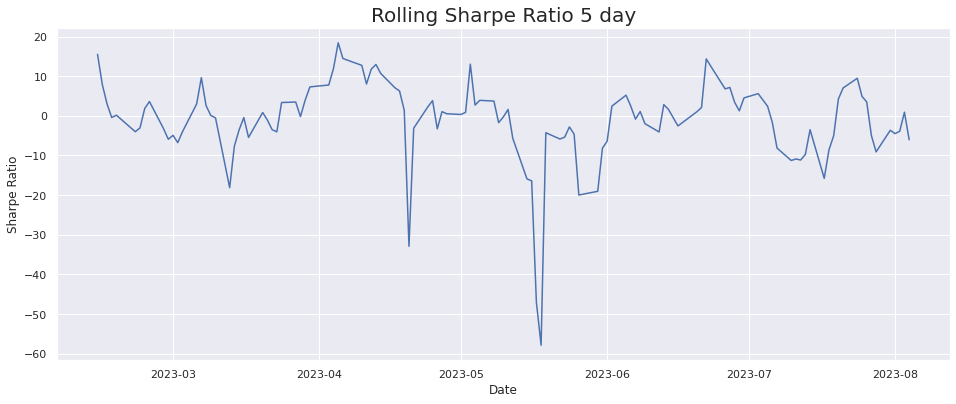

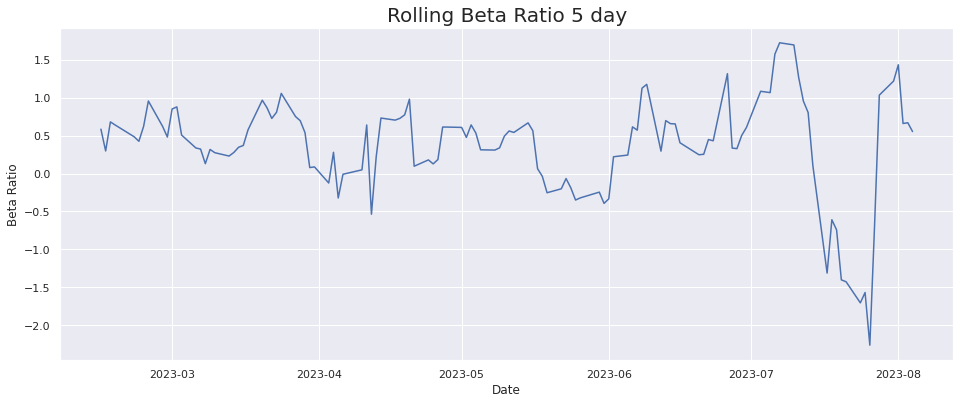

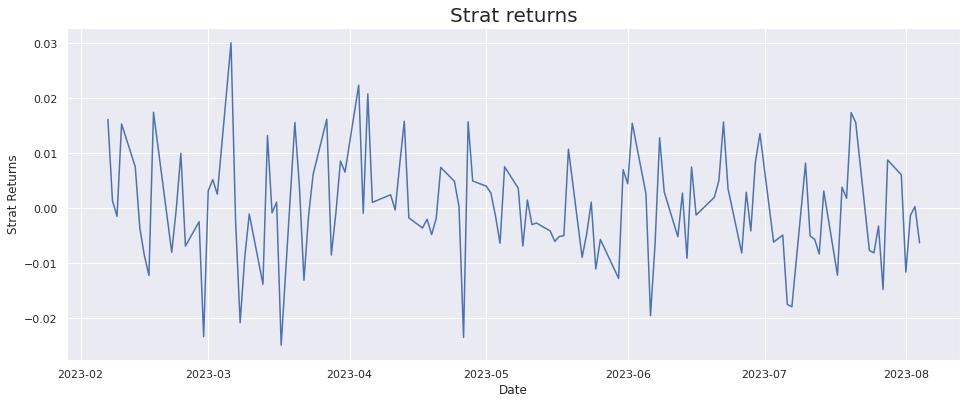

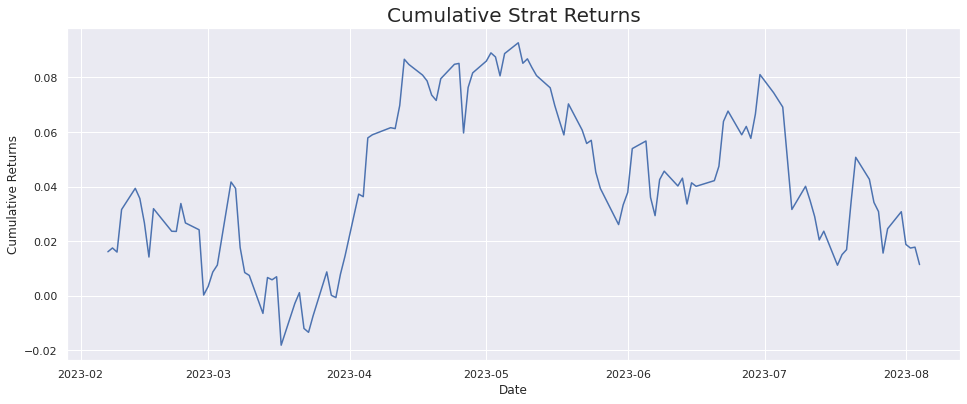

In [7]:
#Data Visualization

plt.plot(pf.timeseries.rolling_sharpe(combined_data['strat returns'], 5))
plt.title('Rolling Sharpe Ratio 5 day', size = 20)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.show()


plt.plot(pf.timeseries.rolling_beta(combined_data['strat returns'], combined_data['S&P returns'],5))
plt.title('Rolling Beta Ratio 5 day', size = 20)
plt.ylabel('Beta Ratio')
plt.xlabel('Date')
plt.show()

plt.plot(combined_data['strat returns'])
plt.title('Strat returns', size = 20)
plt.ylabel('Strat Returns')
plt.xlabel('Date')
plt.show()


# Calculate cumulative returns for the strategy
cumulative_returns = (1 + combined_data['strat returns']).cumprod() - 1

# Plot the cumulative returns
plt.plot(cumulative_returns)
plt.title('Cumulative Strat Returns', size=20)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()

## Investment Strategy Performance Summary

Here is a summary of the performance metrics for the investment strategy:

- **Annual return:** 2.343%  
  The average annual percentage return of the investment strategy over the backtest period.

- **Cumulative returns:** 1.146%  
  The total percentage return of the investment strategy over the entire backtest period.

- **Annual volatility:** 15.84%  
  The annualized standard deviation of the investment strategy's returns, which measures the risk.

- **Sharpe ratio:** 0.22  
  The risk-adjusted return, which takes into account the volatility and risk-free rate. A higher Sharpe ratio indicates better risk-adjusted returns.

- **Calmar ratio:** 0.31  
  The ratio of the annualized return to the maximum drawdown, which measures risk-adjusted return over risk. A higher Calmar ratio indicates better risk-adjusted performance.

- **Stability:** 0.05  
  A measure of how stable the investment strategy's returns are over time. Higher stability suggests more consistent performance.

- **Max drawdown:** -7.455%  
  The maximum percentage loss from a peak to a subsequent trough, indicating the largest drop in portfolio value.

- **Omega ratio:** 1.04  
  The ratio of the probability of positive returns to the probability of negative returns. An Omega ratio greater than 1 indicates a higher likelihood of positive returns.

- **Sortino ratio:** 0.33  
  Similar to the Sharpe ratio, but it only considers downside volatility. A higher Sortino ratio indicates better risk-adjusted returns for negative price movements.

- **Skew:** 0.07  
  A measure of the asymmetry of the investment strategy's return distribution. Positive skewness suggests more frequent positive returns.

- **Kurtosis:** 0.27  
  A measure of the tailedness of the investment strategy's return distribution. Positive kurtosis suggests a more extreme return distribution.

- **Tail ratio:** 0.94  
  The ratio of the average return in the worst 5% of cases to the best 5% of cases. A tail ratio close to 1 indicates a balanced return distribution.

- **Daily value at risk (VaR):** -1.982%  
  The maximum expected loss for a given confidence level (e.g., 1.982% expected loss with a 95% confidence level).

- **Alpha:** -0.04  
  The abnormal return of the investment strategy compared to the benchmark. A positive alpha indicates outperformance relative to the benchmark.

- **Beta:** 0.43  
  The sensitivity of the investment strategy to movements in the benchmark. A beta greater than 1 implies higher volatility than the benchmark.

## Conclusion

The investment strategy demonstrates an annual return of 2.343% with an overall cumulative return of 1.146% over the backtest period. While the Sharpe ratio of 0.22 suggests that the strategy generates some risk-adjusted returns.

The Calmar ratio of 0.31 indicates relatively lower risk-adjusted performance, as the strategy's annualized return is not as significant compared to its maximum drawdown.

The stability value of 0.05 suggests a relatively less stable performance over time, potentially resulting in fluctuations in returns.

The investment strategy experienced a maximum drawdown of -7.455%.

The Sortino ratio of 0.33 highlights the strategy's efficiency in managing downside risk

Overall, the strategy shows low returns and high riskperformance. 